In [2]:
import os
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from pprint import pprint as pp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
def filter_datasets(dataset_path):
    '''
    This function looks into the ResStock datasets, checks buildings with no in.schedules.csv file,
    and ignore them. It also remove building IDs with empty in.schedules.csv

    The fuction returns a list of building IDs that have in.schedules.csv file

    TODO: Remove this function from here. It takes so much time. Also, this is bad implementation
    '''
    exists = []
    root = Path(dataset_path)
    for entry in root.iterdir():
        up00 = entry / 'up00'
        target_file = up00 / 'in.schedules.csv'
        if target_file.is_file() and target_file.stat().st_size > 0:
            exists.append(up00)
    
    return exists

In [ ]:
keep_cols = ['Time', 'Total Electric Power (kW)', 'Total Reactive Power (kVAR)',
                 'Total Electric Energy (kWh)', 'Total Reactive Energy (kVARh)' ]

load_profiles = []
dataset_dir = '/home/deras/gld-opedss-ochre-helics/datasets/cosimulation'
bldgs = filter_datasets(dataset_path=dataset_dir)
seed = 0
random.shuffle(bldgs)
bldgs = bldgs[:4]
for bldg in bldgs:
    bldg = str(bldg)
    bldg_id = bldg.split('/')[-2]
    target_file = bldg + f'/out_{bldg_id}_up00.csv'
    df = pd.read_csv(target_file, usecols=keep_cols)
    df['Time'] = pd.to_datetime(df['Time']).dt.strftime('%H:%M')
    load_profiles.append(df)

/home/deras/gld-opedss-ochre-helics/datasets/cosimulation/89497/up00/out_89497_up00.csv
/home/deras/gld-opedss-ochre-helics/datasets/cosimulation/87382/up00/out_87382_up00.csv
/home/deras/gld-opedss-ochre-helics/datasets/cosimulation/265015/up00/out_265015_up00.csv
/home/deras/gld-opedss-ochre-helics/datasets/cosimulation/187377/up00/out_187377_up00.csv


# Loads Allocation & Transformer Sizing

- In transmission systems, load forecasting is easy.
- In distribution systems, however, loads exhibits higher variability

## Understanding Individual Customer Behavior
### Average Demand:

The average demand can be calculated using $\vec{D}_{n} = \frac{1}{T} \sum_{t=1}^{T} d_{n}$

### Maximum Demand:
The maximum demand can be calculated using $\vec{D}_{n, max} = max {D_{n}}$

### Load Factor:

It is a term used to describe a given load: 

$LF = \frac{\vec{D}_{n}}{\vec{D}_{n, max}}$

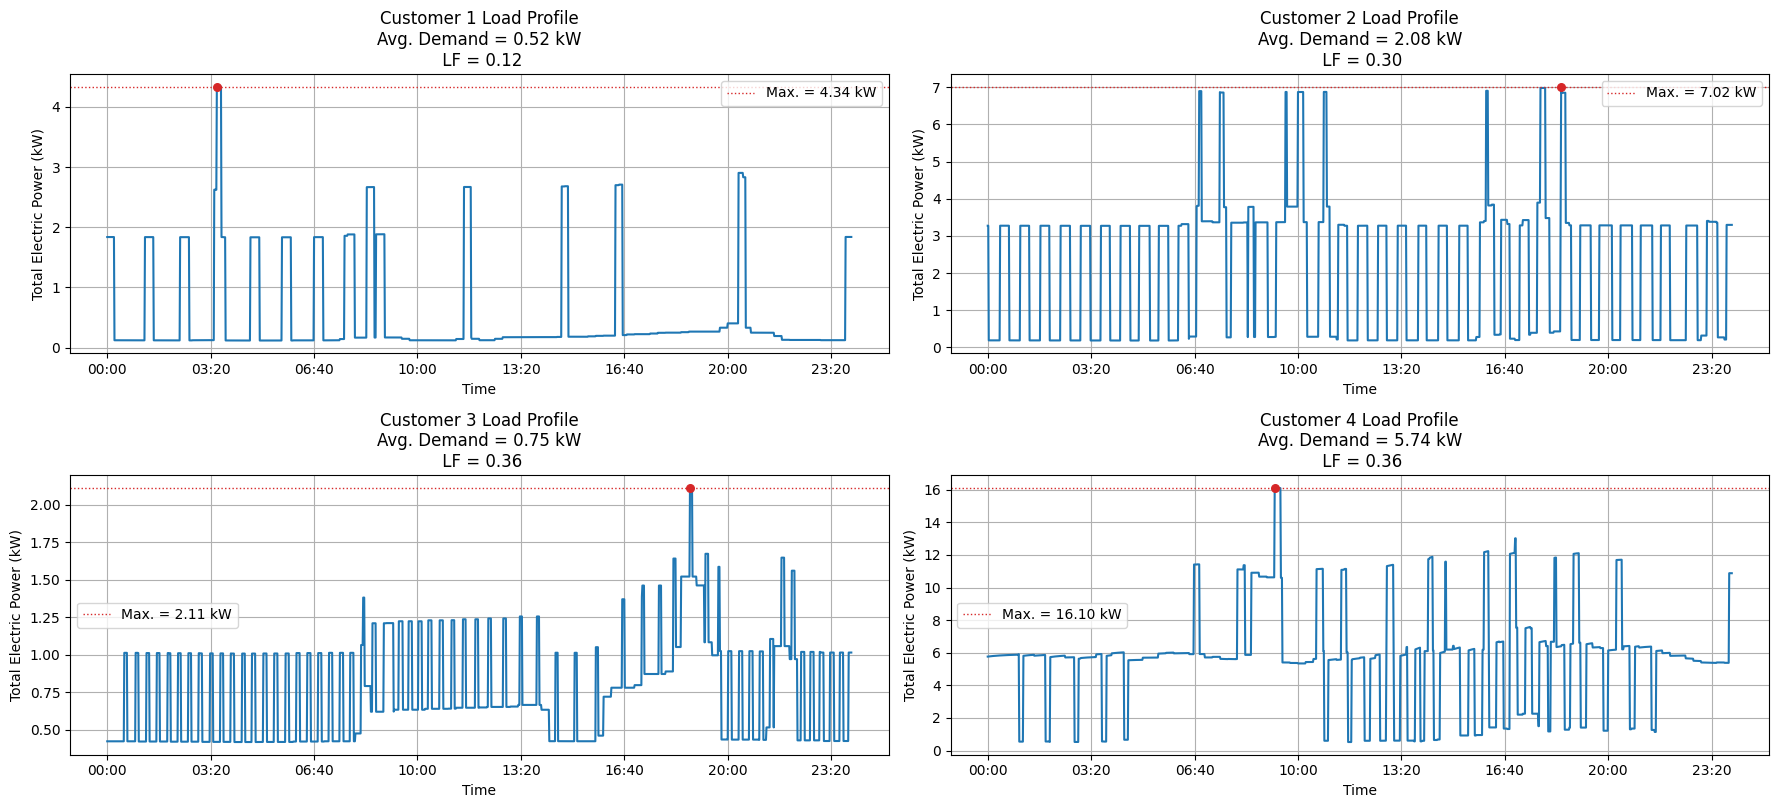

In [20]:
fig, ax = plt.subplots(3,2, figsize=(18,12))
ax = ax.flatten()
ncols = 2
nrows = math.ceil(4 / ncols)

for i, house in enumerate(load_profiles):
    avg_demand = house['Total Electric Power (kW)'].mean()
    max_demand = house['Total Electric Power (kW)'].max()
    t_max = house.loc[house['Total Electric Power (kW)'].idxmax(), 'Time']
    load_factor = avg_demand / max_demand
    ax[i].xaxis.set_major_locator(ticker.MaxNLocator(10))
    ax[i].grid(True)
    ax[i].set_title(f'Customer {i+1} Load Profile\nAvg. Demand = {avg_demand:.2f} kW\n LF = {load_factor:.2f}')
    sns.lineplot(data=house, x='Time', y='Total Electric Power (kW)', ax=ax[i])
    
    # Average Demand
    
    # ax[i].axhline(avg_demand,
    #             linestyle='--',
    #             linewidth=1, 
    #             label=f'Avg = {avg_demand:.2f} kW',
    #             color='tab:green')
    
    # Maximum Demand:
    ax[i].axhline(max_demand,
                linestyle=':',
                linewidth=1, 
                label=f'Max. = {max_demand:.2f} kW',
                color='tab:red')
    
    ax[i].scatter(
        [t_max],
        [max_demand], s=30, zorder=3, color='tab:red'
    )

    ax[i].legend()
fig.tight_layout()

for j in range(4, len(ax)):
    fig.delaxes(ax[j])


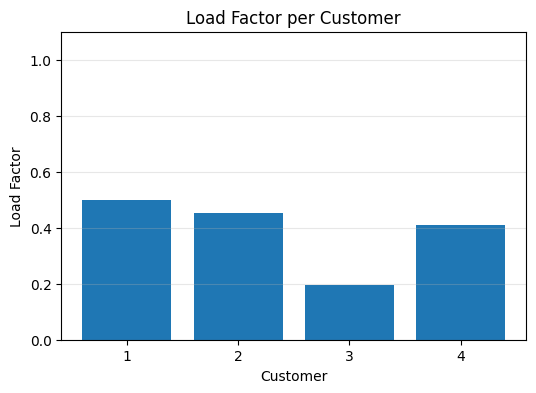

In [6]:
load_factors = []

for house in load_profiles:
    series = house['Total Electric Power (kW)']
    avg_demand = series.mean()
    max_demand = series.max()
    load_factors.append(avg_demand / max_demand)

fig2, ax2 = plt.subplots(figsize=(6,4))
customers = np.arange(1, len(load_factors) + 1)

ax2.bar(customers, load_factors)
ax2.set_xlabel('Customer')
ax2.set_ylabel('Load Factor')
ax2.set_title('Load Factor per Customer')
ax2.set_xticks(customers)
ax2.set_ylim(0, 1.1)
ax2.grid(axis='y', alpha=0.3)


## Understanding Aggregate Behavior:

Consider a scenario where these four customers are connected to a single distribution transformer. We can analyze their behavior by looking into the following:

1) Diversified Demand
2) Max. Diversified Demand
3) Diversity Factor
4) Load Duration Curve (LDC)
5) Max. Non-coincident Demand

### Diversified Demand:
- The sum of kW demand at each time interval per customer is the diversified demand. 
- The diversified demand is what the transformer actually sees, not the single customer peaks!

**For instance:**



Time  |  Customer 1 [kW] | Customer 2 [kW] | Customer 3[kW] | Customer 4 [kW] | Div. Demand (kW) |
------|------------------|-----------------|----------------|-----------------|------------------|
00:00 | 4.5 | 1.5 | 2 | 3 | 9 

In [7]:
# Start from the time column of the first customer, then well iterate from there in the next for loop
diversified = load_profiles[0][['Time']].copy()
diversified['Diversified Power (kW)'] = 0.0

for house in load_profiles:
    diversified['Diversified Power (kW)'] += house['Total Electric Power (kW)'].values

series_div = diversified['Diversified Power (kW)']

avg_div = series_div.mean()

### Max. Diverisifed Demand:
The maximum kW of the loads demand seen by the transformer.

### Diversity Factor:
It is the ratio of the sum of individual max. demands to the max. diverisified demand. See the figure below:

In [9]:
max_div = series_div.max()
lf_div = avg_div / max_div

t_max_div = diversified.loc[series_div.idxmax(), 'Time']

print(f"Diversified avg = {avg_div:.2f} kW")
print(f"Diversified max = {max_div:.2f} kW")
print(f"Diversified LF  = {lf_div:.2f}")

Diversified avg = 2.92 kW
Diversified max = 9.26 kW
Diversified LF  = 0.32


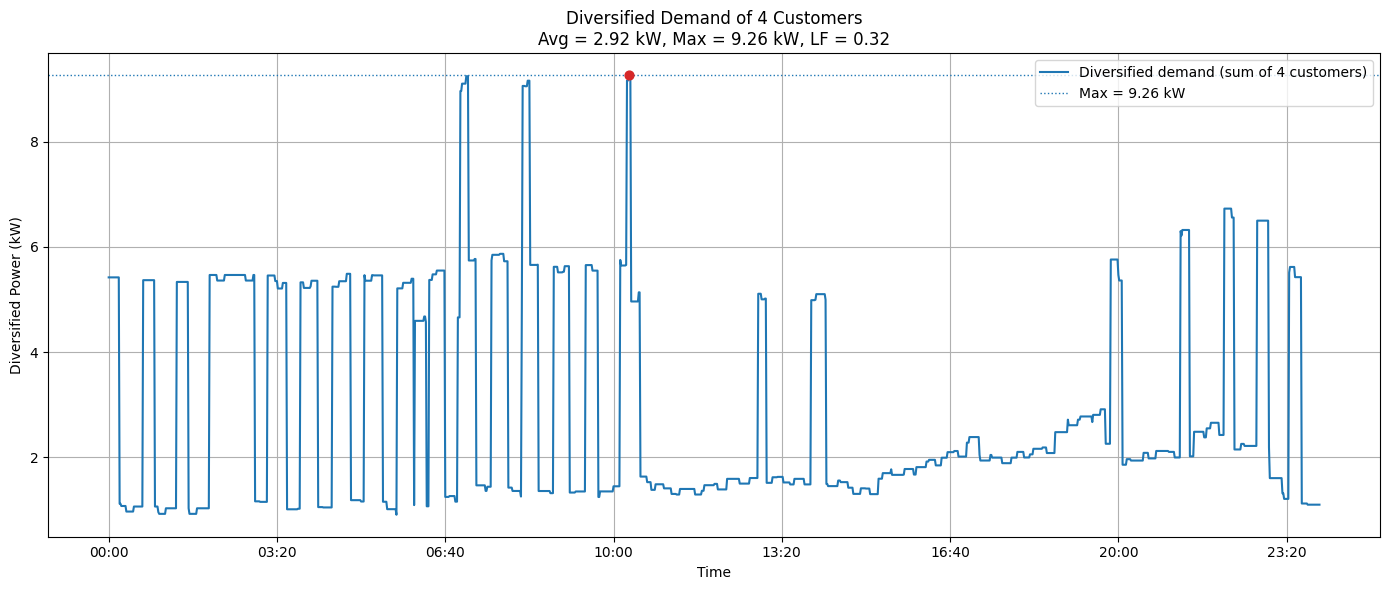

In [10]:
fig, ax = plt.subplots(figsize=(14, 6))

# Diversified load profile
sns.lineplot(
    data=diversified,
    x='Time',
    y='Diversified Power (kW)',
    ax=ax,
    label='Diversified demand (sum of 4 customers)'
)

# Average line
# ax.axhline(
#     avg_div,
#     linestyle='--',
#     linewidth=1,
#     label=f'Average = {avg_div:.2f} kW'
# )

# Maximum line
ax.axhline(
    max_div,
    linestyle=':',
    linewidth=1,
    label=f'Max = {max_div:.2f} kW'
)

# Mark the peak point
ax.scatter(
    [t_max_div],
    [max_div],
    s=40,
    zorder=3, color='tab:red'
)

ax.set_title(
    f'Diversified Demand of 4 Customers\n'
    f'Avg = {avg_div:.2f} kW, Max = {max_div:.2f} kW, LF = {lf_div:.2f}'
)

ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
ax.grid(True)
ax.legend()
fig.tight_layout()

The above figure is very interesting. It shows that the "kW peak" the transformer sees is actually different than the max. sum of individual loads demand. Let's highlight the difference between the two so it can be clearly seen:

In [11]:
# 1) Max demand per customer
max_per_customer = []
for house in load_profiles:
    max_per_customer.append(house['Total Electric Power (kW)'].max())

max_per_customer = np.array(max_per_customer)

# 2) Sum of individual maxima (non-coincident maximum)
sum_individual_max = max_per_customer.sum()

# 3) Diversity factor using diversified max from earlier
# (assuming you already computed: max_div = diversified['Diversified Power (kW)'].max())
DF = sum_individual_max / max_div

print(f"Sum of individual maxima = {sum_individual_max:.2f} kW")
print(f"Diversified maximum      = {max_div:.2f} kW")
print(f"Diversity factor (DF)    = {DF:.2f}")


Sum of individual maxima = 11.01 kW
Diversified maximum      = 9.26 kW
Diversity factor (DF)    = 1.19


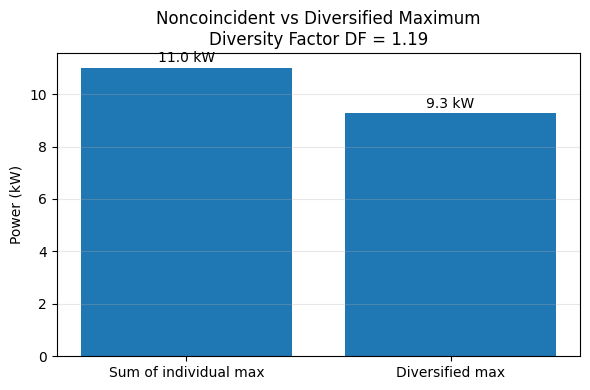

In [12]:
labels = ['Sum of individual max', 'Diversified max']
values = [sum_individual_max, max_div]

fig, ax = plt.subplots(figsize=(6,4))

bars = ax.bar(labels, values)

# Add value labels on top of each bar
for bar, val in zip(bars, values):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        val * 1.01,
        f'{val:.1f} kW',
        ha='center',
        va='bottom'
    )

ax.set_ylabel('Power (kW)')
ax.set_title(f'Noncoincident vs Diversified Maximum\nDiversity Factor DF = {DF:.2f}')
ax.grid(axis='y', alpha=0.3)

fig.tight_layout()


If we simply sum up all the peaks of individual loads, we would end up with the bar on the left. However, calculating the diversified demand, shows that the transformer, in fact, sees a different peak than the individual sum of customer's peaks. The main takeaway here is that:

**We cannot just add the maxima; loads diversity reduces the actual peak seen by the transformer!**

### Load Duration Curve:
This simply shows how often the load stays near its peak and how "strong" the peak is.

In [13]:
# Step 1: Sort values from high to lwo
ldc_values = series_div.sort_values(ascending=False).reset_index(drop=True)

# Step 2: Compute the percentage of time that the loads are at that specific value
num_points = len(ldc_values)
percent_time = (ldc_values.index / num_points) * 100

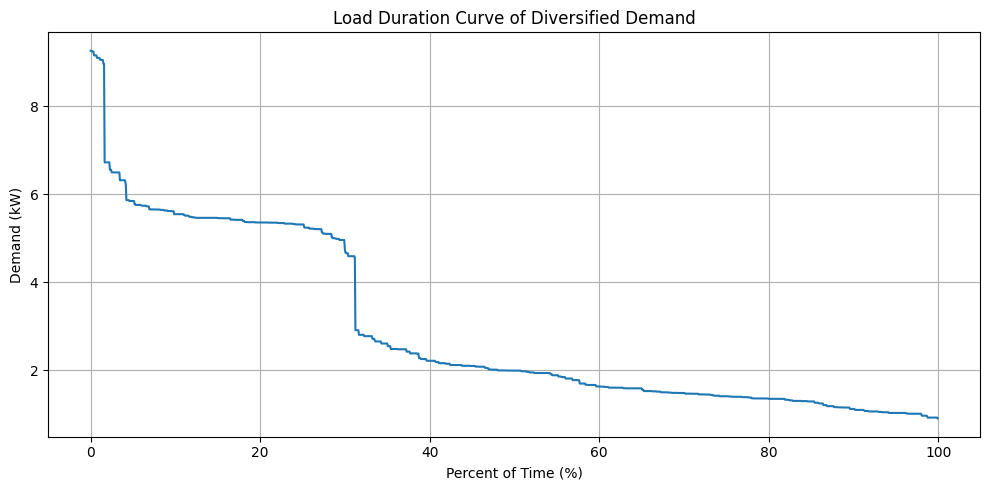

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(x=percent_time, y=ldc_values, ax=ax)

ax.set_xlabel('Percent of Time (%)')
ax.set_ylabel('Demand (kW)')
ax.set_title('Load Duration Curve of Diversified Demand')
ax.grid(True)

plt.tight_layout()

Main Takeaways:

- The above figure shows how long each kW demand stays at different loading levels. Note that almost 0% of the day the load is much lower than its peak, which explains why the load factor is < 1

- 60% of the time the load seen by the transformer is around 7 kW. **Compare this with the peaks we have seen so far!**

- We are applying LDC for transformers, but we can also follow the same concept with feeders, substations, etc.

#### Let's compare the LDC of individual customers to the LDC seen by the transformer

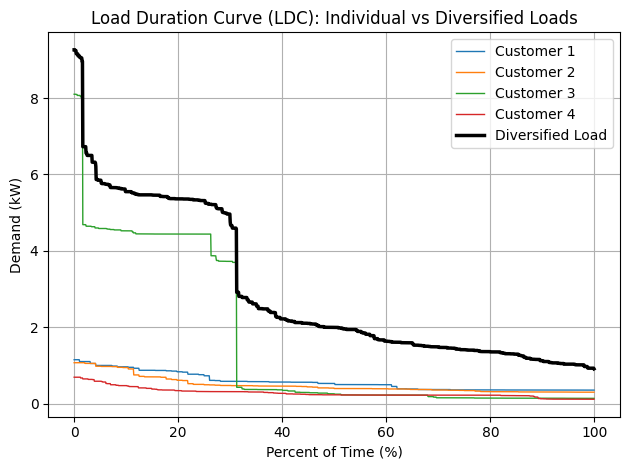

In [15]:
# We'll just repeat the same steps above in one code block, so it is easier to replicate:

# Well loop through the houses and calulate the metrics needed:
for i, house in enumerate(load_profiles):
    series = house['Total Electric Power (kW)']
    
    # Sort from high to low
    ldc_vals = np.sort(series.values)[::-1]
    
    # calculate the percentage of the time each values is seen by the transformer
    percent_time = np.arange(len(ldc_vals)) / len(ldc_vals) * 100
    
    sns.lineplot(
        x=percent_time, 
        y=ldc_vals, 
        label=f'Customer {i+1}', 
        linewidth=1
    )


# Now we calculate the collective LDC and diversified demand (as seen from the transformer)

# Calculte the Diversified demand and the load duration curve (LDC)
series_div = diversified['Diversified Power (kW)'].values

# sort the values
ldc_div = np.sort(series_div)[::-1]


percent_time_div = np.arange(len(ldc_div)) / len(ldc_div) * 100

# Plot LDC
sns.lineplot(
    x=percent_time_div, 
    y=ldc_div, 
    label='Diversified Load', 
    linewidth=2.5, 
    color='black'
)

# plt.axhline(max_div, linestyle=':', linewidth=1, color='red', 
#             label=f'Diversified Max = {max_div:.2f} kW')

# plt.axhline(avg_div, linestyle='--', linewidth=1, color='green', 
#             label=f'Diversified Avg = {avg_div:.2f} kW')


plt.title('Load Duration Curve (LDC): Individual vs Diversified Loads')
plt.xlabel('Percent of Time (%)')
plt.ylabel('Demand (kW)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()